In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

print("alpha",alpha)
print(datetime.datetime.now())

alpha 0.1
2023-05-18 12:36:25.052504


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 1


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_pendulum_bamdp_standardvae_


RuntimeError: Error(s) in loading state_dict for GaussianPolicy:
	size mismatch for linear1.weight: copying a param with shape torch.Size([256, 4]) from checkpoint, the shape in current model is torch.Size([256, 6]).

In [ ]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

In [ ]:
# iwvi.get_real_rollout_bamdppolicy_data()

In [ ]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)

In [ ]:
print(datetime.datetime.now())

# Iter 1

In [ ]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()

In [4]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


NameError: name 'iwvi' is not defined

In [5]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


NameError: name 'iwvi' is not defined

In [6]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

# train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=default_early, weight_alpha=alpha, flag=2)
# iwvi.update_mulogvar_offlinedata()

# train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=default_early, weight_alpha=alpha, flag=3)
# iwvi.update_mulogvar_offlinedata()

NameError: name 'iwvi' is not defined

In [7]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

NameError: name 'train_curve1' is not defined

In [8]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [9]:
print(datetime.datetime.now())

2023-05-18 12:36:25.588802


# Iter2

In [10]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()

NameError: name 'iwvi' is not defined

In [11]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


NameError: name 'iwvi' is not defined

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


NameError: name 'iwvi' is not defined

In [13]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

# train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=2)
# iwvi.update_mulogvar_offlinedata()

# train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=3)
# iwvi.update_mulogvar_offlinedata()

NameError: name 'iwvi' is not defined

In [14]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

NameError: name 'train_curve1' is not defined

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [16]:
print(datetime.datetime.now())

2023-05-18 12:36:26.072735


In [17]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 1600x1200 with 0 Axes>

In [18]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 1600x1200 with 0 Axes>

# Iter 3

In [26]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [27]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.47699  validloss 0.68423±0.00000  bestvalidloss 0.68423  last_update 0
train: iter 1  trainloss 0.45603  validloss 0.58569±0.00000  bestvalidloss 0.58569  last_update 0
train: iter 2  trainloss 0.45091  validloss 0.58254±0.00000  bestvalidloss 0.58254  last_update 0
train: iter 3  trainloss 0.44716  validloss 0.57666±0.00000  bestvalidloss 0.57666  last_update 0
train: iter 4  trainloss 0.45197  validloss 0.57761±0.00000  bestvalidloss 0.57666  last_update 1
train: iter 5  trainloss 0.44295  validloss 0.57538±0.00000  bestvalidloss 0.57538  last_update 0
train: iter 6  trainloss 0.44942  validloss 0.57780±0.00000  bestvalidloss 0.57538  last_update 1
train: iter 7  trainloss 0.44244  validloss 0.57175±0.00000  bestvalidloss 0.57175  last_update 0
train: iter 8  trainloss 0.43680  validloss 0.56666±0.00000  bestvalidloss 0.56666  last_update 0
train: iter 9  trainloss 0.44420  validloss 0.57968±0.00000  bestvalidloss 0.56666  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.41866  validloss 0.57808±0.00000  bestvalidloss 0.56309  last_update 56
train: iter 84  trainloss 0.41642  validloss 0.57489±0.00000  bestvalidloss 0.56309  last_update 57
train: iter 85  trainloss 0.41587  validloss 0.58021±0.00000  bestvalidloss 0.56309  last_update 58
train: iter 86  trainloss 0.41563  validloss 0.58748±0.00000  bestvalidloss 0.56309  last_update 59
train: iter 87  trainloss 0.41572  validloss 0.58234±0.00000  bestvalidloss 0.56309  last_update 60
train: iter 88  trainloss 0.42196  validloss 0.58331±0.00000  bestvalidloss 0.56309  last_update 61
train: iter 89  trainloss 0.41627  validloss 0.57258±0.00000  bestvalidloss 0.56309  last_update 62
train: iter 90  trainloss 0.41742  validloss 0.57255±0.00000  bestvalidloss 0.56309  last_update 63
train: iter 91  trainloss 0.41596  validloss 0.57625±0.00000  bestvalidloss 0.56309  last_update 64
train: iter 92  trainloss 0.41279  validloss 0.56975±0.00000  bestvalidloss 0.56309  last_update 65


([0.47698517683893443,
  0.4560324585065246,
  0.45091245528310536,
  0.4471609707921743,
  0.4519654458388686,
  0.4429463859647512,
  0.44941948633641005,
  0.44243541210889814,
  0.43680329490453007,
  0.4441952880471945,
  0.4392169021070004,
  0.43651089537888765,
  0.4421904467046261,
  0.4373989777639508,
  0.4407066337764263,
  0.43672824688255785,
  0.4344156010076404,
  0.4385080005973577,
  0.43789686877280476,
  0.4330233670771122,
  0.43847826290875674,
  0.43423150572925806,
  0.4337227476760745,
  0.4321636872366071,
  0.43509070090949536,
  0.4330159017816186,
  0.4327027665451169,
  0.4351328656077385,
  0.43186289090663194,
  0.4308295711874962,
  0.4302333600819111,
  0.43260772433131933,
  0.4293505657464266,
  0.43334891069680453,
  0.42375935800373554,
  0.4287136491388083,
  0.4281738046556711,
  0.42789824679493904,
  0.42879913542419673,
  0.42655772864818575,
  0.4282234372571111,
  0.42537531573325393,
  0.4285226305946708,
  0.4262702001258731,
  0.428629587

In [28]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -5.840489239862562
valid_loss:  -8.355079923367501
weight_alpha 1.0 h_min_tilde -12.324187 ell_tilde -6.34340737656355 kappa_tilde 0.004089037466326957
train_loss:  -6.156179195404052
valid_loss:  -6.069826557922363
weight_alpha 0.1 h_min_tilde -12.324187 ell_tilde -6.138908667907714 kappa_tilde 0.00402087309745906


In [29]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

# train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=2)
# iwvi.update_mulogvar_offlinedata()

# train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=3)
# iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1225.99306  validloss -1210.87536±0.00000  bestvalidloss -1210.87536  last_update 0
train: iter 1  trainloss -1226.09876  validloss -1187.66222±0.00000  bestvalidloss -1210.87536  last_update 1
train: iter 2  trainloss -1219.75236  validloss -1221.81605±0.00000  bestvalidloss -1221.81605  last_update 0
train: iter 3  trainloss -1226.50143  validloss -1225.58490±0.00000  bestvalidloss -1225.58490  last_update 0
train: iter 4  trainloss -1230.16683  validloss -1209.40554±0.00000  bestvalidloss -1225.58490  last_update 1
train: iter 5  trainloss -1224.25573  validloss -1199.64151±0.00000  bestvalidloss -1225.58490  last_update 2
train: iter 6  trainloss -1222.63454  validloss -1220.64200±0.00000  bestvalidloss -1225.58490  last_update 3
train: iter 7  trainloss -1228.21126  validloss -1204.62798±0.00000  bestvalidloss -1225.58490  last_update 4
train: iter 8  trainloss -1223.21307  validloss -1211.58122±0.00000  bestva

train: iter 74  trainloss -1219.27604  validloss -1227.16920±0.00000  bestvalidloss -1241.75788  last_update 7
train: iter 75  trainloss -1202.21054  validloss -1169.76674±0.00000  bestvalidloss -1241.75788  last_update 8
train: iter 76  trainloss -1205.42153  validloss -1137.06997±0.00000  bestvalidloss -1241.75788  last_update 9
train: iter 77  trainloss -1219.48987  validloss -1219.14418±0.00000  bestvalidloss -1241.75788  last_update 10
train: iter 78  trainloss -1217.82717  validloss -1202.61914±0.00000  bestvalidloss -1241.75788  last_update 11
train: iter 79  trainloss -1219.97214  validloss -1212.85048±0.00000  bestvalidloss -1241.75788  last_update 12
train: iter 80  trainloss -1218.93844  validloss -1212.62690±0.00000  bestvalidloss -1241.75788  last_update 13
train: iter 81  trainloss -1214.41631  validloss -1212.84395±0.00000  bestvalidloss -1241.75788  last_update 14
train: iter 82  trainloss -1220.65429  validloss -1200.28779±0.00000  bestvalidloss -1241.75788  last_updat

train: iter 147  trainloss -1216.59198  validloss -1196.54423±0.00000  bestvalidloss -1241.75788  last_update 80
train: iter 148  trainloss -1190.76157  validloss -1183.15249±0.00000  bestvalidloss -1241.75788  last_update 81
train: iter 149  trainloss -1190.45107  validloss -1051.87211±0.00000  bestvalidloss -1241.75788  last_update 82
train: iter 150  trainloss -1208.18653  validloss -1174.25192±0.00000  bestvalidloss -1241.75788  last_update 83
train: iter 151  trainloss -1214.31325  validloss -1220.78143±0.00000  bestvalidloss -1241.75788  last_update 84
train: iter 152  trainloss -1216.26225  validloss -1231.62477±0.00000  bestvalidloss -1241.75788  last_update 85
train: iter 153  trainloss -1219.25344  validloss -1203.60276±0.00000  bestvalidloss -1241.75788  last_update 86
train: iter 154  trainloss -1215.85277  validloss -1195.21828±0.00000  bestvalidloss -1241.75788  last_update 87
train: iter 155  trainloss -1217.31534  validloss -1212.57366±0.00000  bestvalidloss -1241.75788

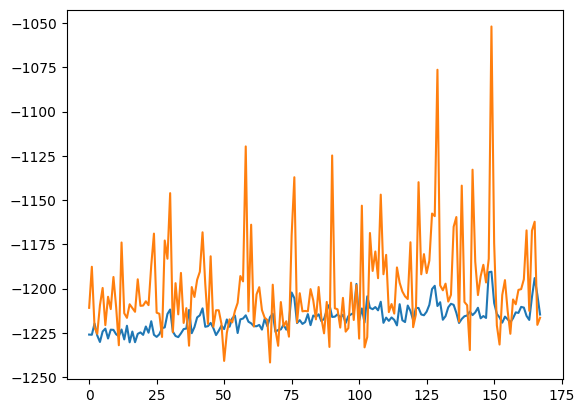

alpha 0.1 default_lr 0.0005


In [30]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [31]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [32]:
print(datetime.datetime.now())

2023-05-17 23:17:44.078826


# 評価関数計算

In [33]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23
predict diverge [-1.87961377  4.77465129 -2.49541634 19.7349131 ] [ 0.07476083 -0.02588125  0.30047468  1.77954699] [18.60177    8.5853815 41.553665  18.481535 ] [ 9.300885   4.2926908 20.776833   9.2407675] sim_timestep 195

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87
predict diverge [-1.83315111  4.64273362 -2.23236664 19.57245628] [ 0.02732374 -0.01709693  0.26859122  1.99134488] [18.60177    8.5853815 41.553665  18.481535 ] [ 9.300885   4.2926908 20.776833   9.2407675] sim_timestep 170

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [34]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.52807  validloss 0.87518±0.00000  bestvalidloss 0.87518  last_update 0
train: iter 1  trainloss 0.50768  validloss 0.82371±0.00000  bestvalidloss 0.82371  last_update 0
train: iter 2  trainloss 0.49742  validloss 0.79002±0.00000  bestvalidloss 0.79002  last_update 0
train: iter 3  trainloss 0.49574  validloss 0.78024±0.00000  bestvalidloss 0.78024  last_update 0
train: iter 4  trainloss 0.49121  validloss 0.78781±0.00000  bestvalidloss 0.78024  last_update 1
train: iter 5  trainloss 0.49364  validloss 0.76955±0.00000  bestvalidloss 0.76955  last_update 0
train: iter 6  trainloss 0.48756  validloss 0.76376±0.00000  bestvalidloss 0.76376  last_update 0
train: iter 7  trainloss 0.48081  validloss 0.74909±0.00000  bestvalidloss 0.74909  last_update 0
train: iter 8  trainloss 0.47942  validloss 0.75718±0.00000  bestvalidloss 0.74909  last_update 1
train: iter 9  trainloss 0.48075  validloss 0.74460±0.00000  bestvalidloss 0.74460  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.41117  validloss 0.63146±0.00000  bestvalidloss 0.63146  last_update 0
train: iter 84  trainloss 0.41572  validloss 0.63166±0.00000  bestvalidloss 0.63146  last_update 1
train: iter 85  trainloss 0.40974  validloss 0.64097±0.00000  bestvalidloss 0.63146  last_update 2
train: iter 86  trainloss 0.41671  validloss 0.64378±0.00000  bestvalidloss 0.63146  last_update 3
train: iter 87  trainloss 0.41184  validloss 0.63483±0.00000  bestvalidloss 0.63146  last_update 4
train: iter 88  trainloss 0.41197  validloss 0.63664±0.00000  bestvalidloss 0.63146  last_update 5
train: iter 89  trainloss 0.41143  validloss 0.64811±0.00000  bestvalidloss 0.63146  last_update 6
train: iter 90  trainloss 0.41492  validloss 0.63141±0.00000  bestvalidloss 0.63141  last_update 0
train: iter 91  trainloss 0.41436  validloss 0.64135±0.00000  bestvalidloss 0.63141  last_update 1
train: iter 92  trainloss 0.41261  validloss 0.64307±0.00000  bestvalidloss 0.63141  last_update 2
train: ite

train: iter 165  trainloss 0.40221  validloss 0.63619±0.00000  bestvalidloss 0.62561  last_update 25
train: iter 166  trainloss 0.40110  validloss 0.63270±0.00000  bestvalidloss 0.62561  last_update 26
train: iter 167  trainloss 0.40430  validloss 0.64033±0.00000  bestvalidloss 0.62561  last_update 27
train: iter 168  trainloss 0.40024  validloss 0.63277±0.00000  bestvalidloss 0.62561  last_update 28
train: iter 169  trainloss 0.40039  validloss 0.63627±0.00000  bestvalidloss 0.62561  last_update 29
train: iter 170  trainloss 0.40553  validloss 0.63797±0.00000  bestvalidloss 0.62561  last_update 30
train: iter 171  trainloss 0.40059  validloss 0.64884±0.00000  bestvalidloss 0.62561  last_update 31
train: iter 172  trainloss 0.39970  validloss 0.62706±0.00000  bestvalidloss 0.62561  last_update 32
train: iter 173  trainloss 0.40040  validloss 0.63272±0.00000  bestvalidloss 0.62561  last_update 33
train: iter 174  trainloss 0.39770  validloss 0.64760±0.00000  bestvalidloss 0.62561  last_

([0.5280738389119506,
  0.5076801925897598,
  0.4974189715459943,
  0.4957414038479328,
  0.4912069054320455,
  0.49363815821707246,
  0.48755574952811004,
  0.4808106589131057,
  0.47941572647541764,
  0.4807489519938827,
  0.4767239183187485,
  0.47165777925401925,
  0.46881557647138833,
  0.46083275116980077,
  0.4575420692563057,
  0.45401661433279517,
  0.45820501251146195,
  0.448542040027678,
  0.44617452900856736,
  0.44462580885738134,
  0.43932935418561103,
  0.4388353440910578,
  0.4377675184980035,
  0.4363527333363891,
  0.4357064452022314,
  0.4338190970942378,
  0.4340057363733649,
  0.4306415384635329,
  0.4318573405966163,
  0.42983712777495386,
  0.4330396123230457,
  0.4306882418692112,
  0.43089690348133447,
  0.42986231166869404,
  0.42933151703327893,
  0.4321661587804556,
  0.4283931117504835,
  0.42733946181833743,
  0.4248729467391968,
  0.4269191356375813,
  0.42356820683926344,
  0.4238692995160818,
  0.42643097676336766,
  0.42480239029973743,
  0.4213917521

In [35]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -4.274554335337877
valid_loss:  -9.296563325047495
weight_alpha 1.0 h_min_tilde -12.32078 ell_tilde -5.2789561332798005 kappa_tilde 0.0037684037483393428
train_loss:  -5.674252729415892
valid_loss:  -5.580573593902588
weight_alpha 0.1 h_min_tilde -12.32078 ell_tilde -5.655516902313232 kappa_tilde 0.003873391168533991


In [36]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 70.70994  validloss 84.69536±0.00000  bestvalidloss 84.69536  last_update 0
train: iter 1  trainloss 46.44956  validloss 52.72940±0.00000  bestvalidloss 52.72940  last_update 0
train: iter 2  trainloss 28.94929  validloss 32.98936±0.00000  bestvalidloss 32.98936  last_update 0
train: iter 3  trainloss 16.94613  validloss 18.86094±0.00000  bestvalidloss 18.86094  last_update 0
train: iter 4  trainloss 9.70584  validloss 11.47147±0.00000  bestvalidloss 11.47147  last_update 0
train: iter 5  trainloss 5.15980  validloss 6.52613±0.00000  bestvalidloss 6.52613  last_update 0
train: iter 6  trainloss 2.48750  validloss 2.44460±0.00000  bestvalidloss 2.44460  last_update 0
train: iter 7  trainloss 0.36383  validloss 0.78207±0.00000  bestvalidloss 0.78207  last_update 0
train: iter 8  trainloss -0.44423  validloss -0.76200±0.00000  bestvalidloss -0.76200  last_update 0
train: iter 9  trainloss -1.26260  validloss -1.54495±0.00000  bestvalidloss -1.54495  last_update 0


train: iter 83  trainloss -1.97170  validloss -1.88486±0.00000  bestvalidloss -2.17402  last_update 6
train: iter 84  trainloss -2.00992  validloss -2.13273±0.00000  bestvalidloss -2.17402  last_update 7
train: iter 85  trainloss -1.84643  validloss -1.75875±0.00000  bestvalidloss -2.17402  last_update 8
train: iter 86  trainloss -2.06883  validloss -1.95527±0.00000  bestvalidloss -2.17402  last_update 9
train: iter 87  trainloss -1.87907  validloss -1.87509±0.00000  bestvalidloss -2.17402  last_update 10
train: iter 88  trainloss -1.87492  validloss -2.14147±0.00000  bestvalidloss -2.17402  last_update 11
train: iter 89  trainloss -1.97511  validloss -2.00997±0.00000  bestvalidloss -2.17402  last_update 12
train: iter 90  trainloss -1.91014  validloss -1.93082±0.00000  bestvalidloss -2.17402  last_update 13
train: iter 91  trainloss -1.95821  validloss -1.85482±0.00000  bestvalidloss -2.17402  last_update 14
train: iter 92  trainloss -1.96690  validloss -2.10322±0.00000  bestvalidloss

train: iter 168  trainloss -1.92388  validloss -1.92723±0.00000  bestvalidloss -2.19258  last_update 56
train: iter 169  trainloss -1.79820  validloss -2.12336±0.00000  bestvalidloss -2.19258  last_update 57
train: iter 170  trainloss -1.94273  validloss -2.02397±0.00000  bestvalidloss -2.19258  last_update 58
train: iter 171  trainloss -1.92549  validloss -2.08342±0.00000  bestvalidloss -2.19258  last_update 59
train: iter 172  trainloss -1.96917  validloss -2.13235±0.00000  bestvalidloss -2.19258  last_update 60
train: iter 173  trainloss -1.96822  validloss -2.06558±0.00000  bestvalidloss -2.19258  last_update 61
train: iter 174  trainloss -1.93744  validloss -2.09436±0.00000  bestvalidloss -2.19258  last_update 62
train: iter 175  trainloss -1.80934  validloss -2.10383±0.00000  bestvalidloss -2.19258  last_update 63
train: iter 176  trainloss -1.86332  validloss -1.87655±0.00000  bestvalidloss -2.19258  last_update 64
train: iter 177  trainloss -2.00710  validloss -1.99849±0.00000 

train: iter 256  trainloss -1.95043  validloss -2.12202±0.00000  bestvalidloss -2.19730  last_update 74
train: iter 257  trainloss -1.91546  validloss -2.16701±0.00000  bestvalidloss -2.19730  last_update 75
train: iter 258  trainloss -1.82076  validloss -2.08088±0.00000  bestvalidloss -2.19730  last_update 76
train: iter 259  trainloss -1.91958  validloss -1.99516±0.00000  bestvalidloss -2.19730  last_update 77
train: iter 260  trainloss -1.92071  validloss -2.12052±0.00000  bestvalidloss -2.19730  last_update 78
train: iter 261  trainloss -1.88577  validloss -1.84003±0.00000  bestvalidloss -2.19730  last_update 79
train: iter 262  trainloss -1.98847  validloss -2.07776±0.00000  bestvalidloss -2.19730  last_update 80
train: iter 263  trainloss -1.97727  validloss -2.04621±0.00000  bestvalidloss -2.19730  last_update 81
train: iter 264  trainloss -1.92422  validloss -2.02824±0.00000  bestvalidloss -2.19730  last_update 82
train: iter 265  trainloss -1.90446  validloss -1.91126±0.00000 

In [37]:
print(iwvi.initial_belief)


Parameter containing:
tensor([-2.3610, -6.6489], requires_grad=True)


In [38]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 0.89460  validloss 5.25661±0.00000  bestvalidloss 5.25661  last_update 0
train: iter 1  trainloss 0.89250  validloss 4.39030±0.00000  bestvalidloss 4.39030  last_update 0
train: iter 2  trainloss 0.87586  validloss 4.58511±0.00000  bestvalidloss 4.39030  last_update 1
train: iter 3  trainloss 0.83431  validloss 5.62974±0.00000  bestvalidloss 4.39030  last_update 2
train: iter 4  trainloss 0.84060  validloss 5.06002±0.00000  bestvalidloss 4.39030  last_update 3
train: iter 5  trainloss 0.84883  validloss 4.65640±0.00000  bestvalidloss 4.39030  last_update 4
train: iter 6  trainloss 0.84780  validloss 5.08655±0.00000  bestvalidloss 4.39030  last_update 5
train: iter 7  trainloss 0.85434  validloss 4.51768±0.00000  bestvalidloss 4.39030  last_update 6
train: iter 8  trainloss 0.88482  validloss 5.66589±0.00000  bestvalidloss 4.39030  last_update 7
train: iter 9  trainloss 0.85129  validloss 4.92480±0.00000  bestvalidloss 4.39030  last_update 8
train: iter 10  trai

train: iter 84  trainloss 0.85047  validloss 5.56721±0.00000  bestvalidloss 3.78835  last_update 14
train: iter 85  trainloss 0.85939  validloss 4.42555±0.00000  bestvalidloss 3.78835  last_update 15
train: iter 86  trainloss 0.83863  validloss 4.97130±0.00000  bestvalidloss 3.78835  last_update 16
train: iter 87  trainloss 0.84870  validloss 4.25192±0.00000  bestvalidloss 3.78835  last_update 17
train: iter 88  trainloss 0.85231  validloss 5.15687±0.00000  bestvalidloss 3.78835  last_update 18
train: iter 89  trainloss 0.85374  validloss 3.84876±0.00000  bestvalidloss 3.78835  last_update 19
train: iter 90  trainloss 0.87311  validloss 5.15530±0.00000  bestvalidloss 3.78835  last_update 20
train: iter 91  trainloss 0.85190  validloss 5.35873±0.00000  bestvalidloss 3.78835  last_update 21
train: iter 92  trainloss 0.85527  validloss 4.45045±0.00000  bestvalidloss 3.78835  last_update 22
train: iter 93  trainloss 0.85394  validloss 5.20259±0.00000  bestvalidloss 3.78835  last_update 23


train: iter 167  trainloss 0.84642  validloss 5.29023±0.00000  bestvalidloss 3.78835  last_update 97
train: iter 168  trainloss 0.86003  validloss 4.91687±0.00000  bestvalidloss 3.78835  last_update 98
train: iter 169  trainloss 0.83926  validloss 4.97825±0.00000  bestvalidloss 3.78835  last_update 99
train: iter 170  trainloss 0.84512  validloss 4.21080±0.00000  bestvalidloss 3.78835  last_update 100
train: fin


In [39]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-9.0100)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-3.2770)


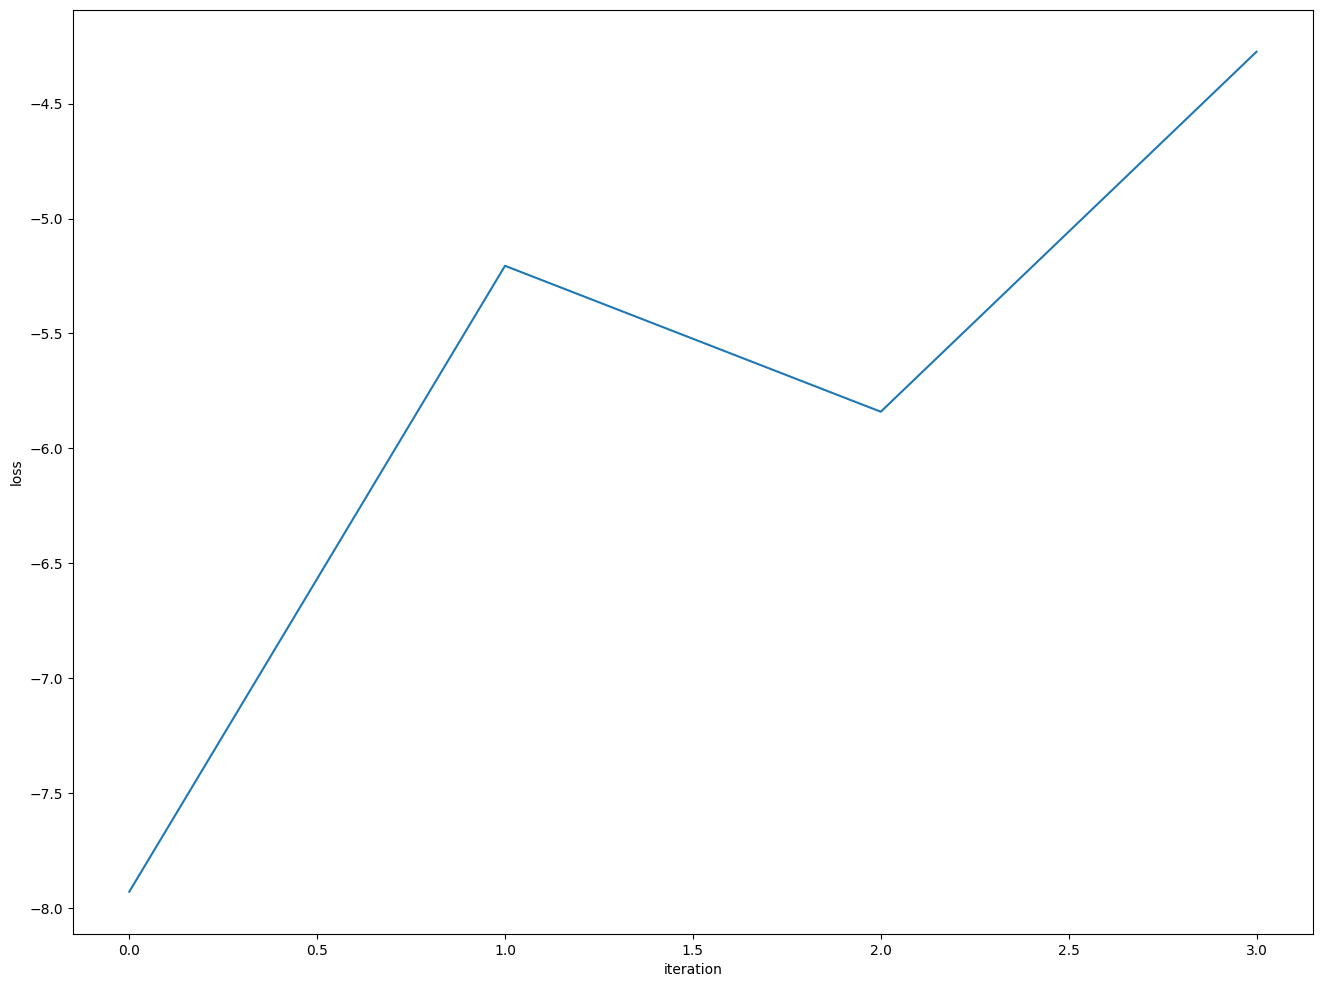

In [40]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

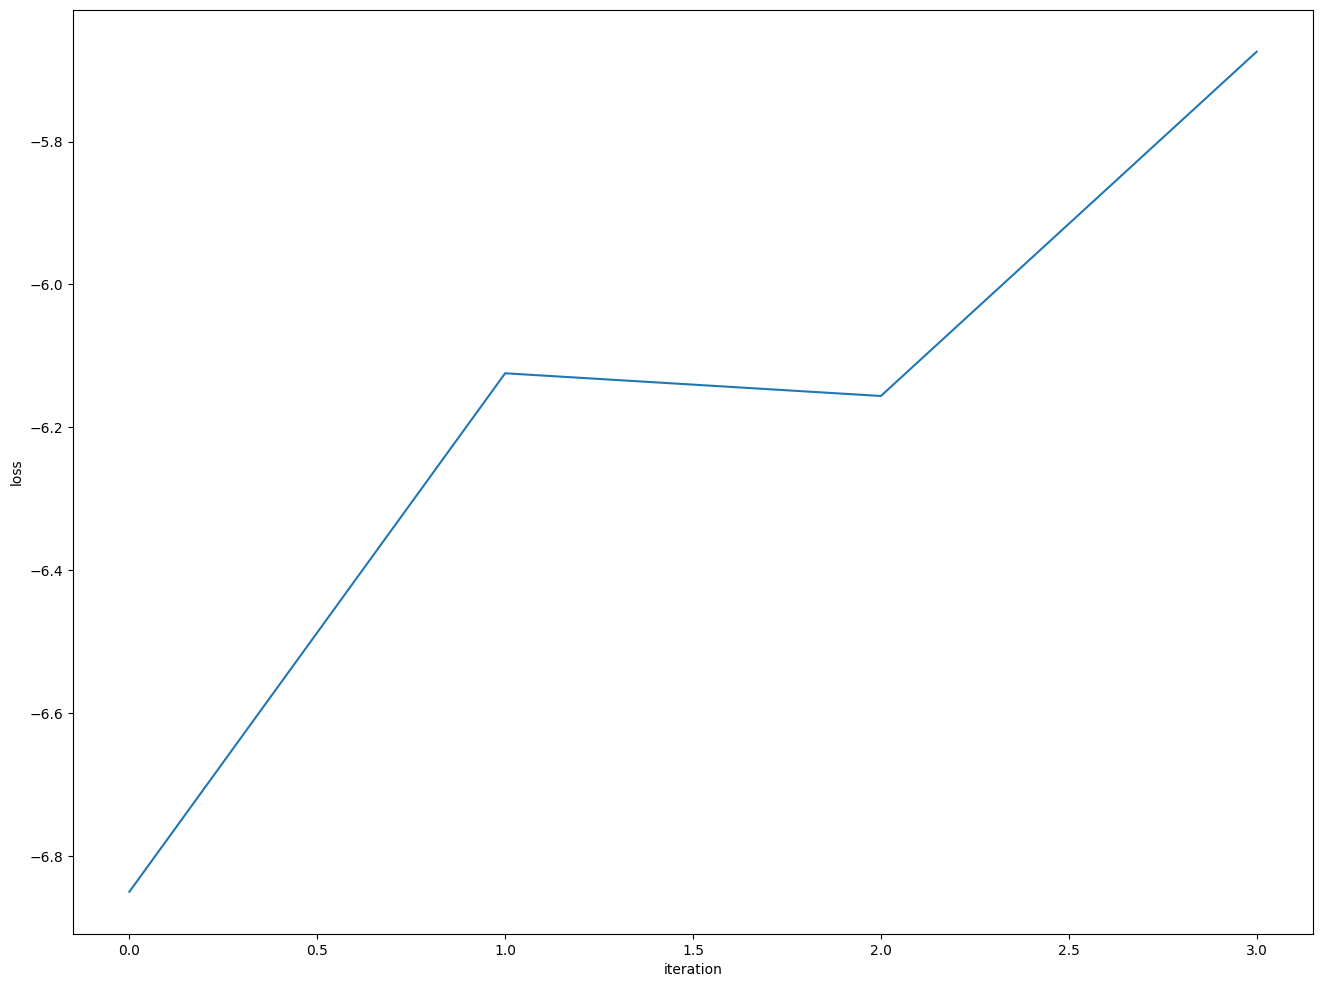

In [41]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")